In [36]:
import numpy as np
import seaborn as sns
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import KNNImputer
import pickle
import optuna
print(f'Pickle Version: {pickle.format_version}')

Pickle Version: 4.0


In [2]:
_pth_tst = 'data/test_2022-08-08.csv'
_pth_trn = 'data/train_2021-12-24.csv'
_pth_emb = 'data/embeddings.pkl'
_pth_enc ='data/encoders.pkl'

train = pd.read_csv(_pth_trn)
test = pd.read_csv(_pth_tst)

with open(_pth_emb, 'rb') as handle:
    embeds = pickle.load(handle)

In [3]:
# with open(_pth_enc, 'rb') as handle:
#     ecode = pickle.load(handle)

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99144 entries, 0 to 99143
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sale_Price          99144 non-null  float64
 1   Odometer            99119 non-null  float64
 2   Power               99090 non-null  float64
 3   Fuel_Urban          87810 non-null  float64
 4   Make_Code           99144 non-null  object 
 5   Family_Code         99144 non-null  object 
 6   Year_Group          99144 non-null  int64  
 7   Region_Description  99144 non-null  object 
 8   Vehicle_Code        99144 non-null  int64  
 9   adv_date            99144 non-null  object 
 10  sld_date            99144 non-null  object 
 11  inventory_days      99144 non-null  int64  
 12  age_list_day        99144 non-null  int64  
 13  age_sell_day        99144 non-null  int64  
 14  sld_wknum           99144 non-null  int64  
 15  adv_wknum           99144 non-null  int64  
 16  km_p

In [5]:
train.columns

Index(['Sale_Price', 'Odometer', 'Power', 'Fuel_Urban', 'Make_Code',
       'Family_Code', 'Year_Group', 'Region_Description', 'Vehicle_Code',
       'adv_date', 'sld_date', 'inventory_days', 'age_list_day',
       'age_sell_day', 'sld_wknum', 'adv_wknum', 'km_per_day',
       'fuel_per_power', 'odo_per_fuel', 'odo_per_power', 'pow_times_odo'],
      dtype='object')

In [13]:
feat_cols = ['Odometer', 'Power', 'Fuel_Urban', 'inventory_days', 
             'age_sell_day', 'km_per_day', 'fuel_per_power', 
             'odo_per_fuel', 'odo_per_power','pow_times_odo']

enc_cols = list(embeds)
enc_cols

['Make_Code', 'Family_Code', 'Region_Description']

In [11]:
def get_embedded_feat(feat, encod_dict, feat_name='Family_Code'):
    '''Return embeddings from feature column using encoded dict
    '''
    feat_df = feat.to_frame()
    encodings = encod_dict[feat_name].reset_index()
    feat_tranf = feat_df.merge(encodings, how='left', left_on=[feat_name], right_on=['index'], indicator=True)
    print(feat_tranf._merge.value_counts())
    return feat_tranf.loc[:,[c for c in encodings.columns if c.startswith(feat_name)]]

In [56]:
embed_dflist = []
embed_dflist_test = []


for f in list(embeds):
    df = get_embedded_feat(train[f], embeds, feat_name=f)
    embed_dflist.append(df)
    df_test = get_embedded_feat(test[f], embeds, feat_name=f)
    embed_dflist_test.append(df_test)

both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17496
left_only         1
right_only        0
Name: _merge, dtype: int64
both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17461
left_only        36
right_only        0
Name: _merge, dtype: int64
both          99144
left_only         0
right_only        0
Name: _merge, dtype: int64
both          17497
left_only         0
right_only        0
Name: _merge, dtype: int64


In [57]:
X_train_df = pd.concat([train.loc[:,feat_cols]]+embed_dflist, axis=1)
y_train = train.loc[:,'Sale_Price']

X_test_df = pd.concat([test.loc[:,feat_cols]]+embed_dflist_test, axis=1)
y_test = test.loc[:,'Sale_Price']

In [40]:
knn = KNNImputer()
X_train = knn.fit_transform(X_train_df)

In [58]:
X_test = knn.fit_transform(X_test_df)

<AxesSubplot:>

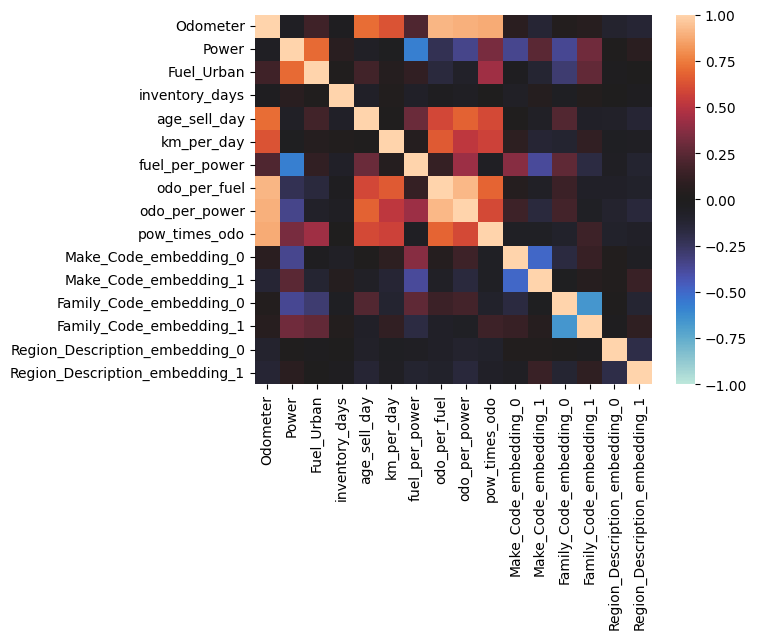

In [16]:
sns.heatmap(X_train_df.corr(), vmax=1, vmin=-1, center=0)

In [49]:
# Tuning with optuna
def objective(trial):
    alpha = trial.suggest_float("alpha", 1e-8, 1e8, log=True)
    pipe = make_pipeline(StandardScaler(), Ridge(alpha=alpha))
    
    return cross_val_score(pipe, X_train, y_train, n_jobs=-1, cv=10, scoring='r2').mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)

[I 2022-08-23 00:04:29,128] A new study created in memory with name: no-name-1a2c7316-0fab-410b-9e3b-856853b3fe74
[I 2022-08-23 00:04:29,640] Trial 0 finished with value: 0.7328638234682057 and parameters: {'alpha': 40338.59629704958}. Best is trial 0 with value: 0.7328638234682057.
[I 2022-08-23 00:04:29,908] Trial 1 finished with value: 0.7769430828897047 and parameters: {'alpha': 0.045707859338934856}. Best is trial 1 with value: 0.7769430828897047.
[I 2022-08-23 00:04:30,168] Trial 2 finished with value: 0.7769430288691719 and parameters: {'alpha': 2.2519380149219873e-06}. Best is trial 1 with value: 0.7769430828897047.
[I 2022-08-23 00:04:30,428] Trial 3 finished with value: -0.009389432638780748 and parameters: {'alpha': 23490401.745561242}. Best is trial 1 with value: 0.7769430828897047.
[I 2022-08-23 00:04:30,706] Trial 4 finished with value: 0.7769430290195136 and parameters: {'alpha': 0.00012944251952311418}. Best is trial 1 with value: 0.7769430828897047.
[I 2022-08-23 00:04

In [53]:
pipe = make_pipeline(StandardScaler(), Ridge(**study.best_params))
print(pipe)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=804.9512427395545))])


In [54]:
pipe.fit(X_train,y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('ridge', Ridge(alpha=804.9512427395545))])

In [65]:
from sklearn.metrics import r2_score, explained_variance_score

In [68]:
y_pred = pipe.predict(X_test)
y_pred_tr = pipe.predict(X_train)

In [73]:
r2_score(y_train,y_pred_tr,multioutput='variance_weighted'), explained_variance_score(y_train,y_pred_tr)

(0.7852280452743209, 0.785228045274321)

In [74]:
r2_score(y_test,y_pred,multioutput='variance_weighted'), explained_variance_score(y_test,y_pred)

(0.6805147579244221, 0.7498411620463616)

In [79]:
ridge_model = pipe.named_steps['ridge']
ridge_model.get_params()

{'alpha': 804.9512427395545,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [84]:
sorted(list(zip(ridge_model.coef_, X_train_df.columns)), key=lambda x: x[0], reverse=True)

[(7999.004311157014, 'Power'),
 (4694.145291100771, 'Family_Code_embedding_1'),
 (3911.8166558680355, 'odo_per_power'),
 (3720.2042262843174, 'Make_Code_embedding_1'),
 (414.8182007180725, 'fuel_per_power'),
 (107.78315868255292, 'Region_Description_embedding_0'),
 (59.233099819219234, 'Odometer'),
 (22.325722082584104, 'inventory_days'),
 (-18.226031370906597, 'Region_Description_embedding_1'),
 (-327.47803301092245, 'km_per_day'),
 (-1588.7199650052378, 'odo_per_fuel'),
 (-2395.983995918772, 'Fuel_Urban'),
 (-3884.9205115450486, 'age_sell_day'),
 (-4291.884405340089, 'Make_Code_embedding_0'),
 (-4541.409946831704, 'Family_Code_embedding_0'),
 (-4779.1706607453525, 'pow_times_odo')]